Esse Notebook será dedicado a experimentar como os modelos classicos aprendem com os dados youtube e spotify.

* Primeiro será feito um teste com os modelos sem nenhum ajuste previo para entender como tão prevendo os dados em primeiro momento.

* Em segundo momento será testado como a idade dos dados ta afetenado previsão do modelo em 3 diferentes faixas de tempo.

* Retirar os outliers e ver como o modelo padrão de menor erro se comporta

* Será testado se e qual normalizador traz a melhor predição

possiveis melhorias:
*   ~~tirar os outliers de engajamento~~
*   ~~utilizar tecnicas como SMOTE para aumentar o numero de musicas com ate 30 dias~~ (Não funcionou com os dados)

Descobertas:
* Utilizar apenas musicas recentes não garante que vamos ter resultados melhores, portanto pode usar todas as musicas
* Musicas com mais dias são mais faceis de prever
* Retirar os outliers trouxe melhoria
* Se retirar os outliers do conjunto de treinamento o numero de streams ajuda na predição
* Normalizar ajuda um pouco a predição, foi testado e se pode utilizar qualquer normalizador entre MinMaxScaler, StandardScaler, RobustScaler que tem o mesmo/similar desempenho

Estrutura de processamento final:

1. Tratamento: Limpeza das colunas, linhas com nan, Retirada de outliers da coluna de engajamento

2. Preprocessamento: extração de musicas com 0 a ate 30 dias, de 31 a 90 e de 91 a 365 dias, retirada a mostras desses conjuntos para serem usadas no teste do modelo, formação do conjunto de treino com todas as musicas e a normalização dos dados de treino e teste.

3. Teste com os modelos: será usados os modelos LinearRegression, RandomForestRegressor, MLPRegressor, xgb
    

Proximo passo: Testar metodos de tunin nos 4 modelos 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer

# Tratamento dos dados

In [209]:
spotify_youtube_pt1 = pd.read_csv("Dados/spotify_youtube_up_pt1.csv")
spotify_youtube_pt2 = pd.read_csv("Dados/spotify_youtube_up_pt2.csv")

In [210]:
data_extracao = pd.to_datetime("2023-02-07")
spotify_youtube_pt1["upload_date"] = pd.to_datetime(spotify_youtube_pt1["upload_date"])
spotify_youtube_pt1["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt1["upload_date"]).dt.days

spotify_youtube_pt2["upload_date"] = pd.to_datetime(spotify_youtube_pt2["upload_date"])
spotify_youtube_pt2["dias_na_plataforma"] = (data_extracao - spotify_youtube_pt2["upload_date"]).dt.days

In [211]:
spotify_youtube = pd.concat([spotify_youtube_pt1,spotify_youtube_pt2])

In [212]:
spotify_youtube_dummies= pd.get_dummies(spotify_youtube,columns=['Album_type'], dtype=int)

In [213]:
spotify_youtube_dummies['artist_number'] = spotify_youtube_dummies['Artist'].str.split(',').str.len()
spotify_youtube_dummies['engagement_rate'] = spotify_youtube_dummies.apply(lambda row: (row['Likes'] + row['Comments']) / row['Views'] * 100 if row['Views'] > 0 else 0, axis=1)

In [214]:
columns_drop=['Unnamed: 0', 'Artist', 'Url_spotify', 'Track', 'Album', 'Uri','Url_youtube', 'Title', 'Channel', 'Views', 'Likes','Comments', 'Description', 'Licensed', 'official_video', 'upload_date']
spotify_youtube_df=spotify_youtube_dummies.drop(columns=columns_drop)

In [215]:
spotify_youtube_limpo=spotify_youtube_df.dropna(subset=['Danceability','Energy','Key','Loudness','Speechiness','Acousticness', 'Instrumentalness','Liveness','Valence','Tempo','Duration_ms','Stream','engagement_rate'])

# Preparação dos dados para os experimentos

In [216]:
youtube_30_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<31]
youtube_90_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<91]
youtube_365_df=spotify_youtube_limpo[spotify_youtube_limpo['dias_na_plataforma']<366]

In [217]:
spotify_youtube_df_366_more = spotify_youtube_limpo.drop(youtube_365_df.index)
spotify_youtube_df_91_365 = youtube_365_df.drop(youtube_90_df.index)
spotify_youtube_df_31_90 = youtube_365_df.drop(youtube_30_df.index)

Total number of outliers in column engagement_rate: 573
Lower limit: -0.48890200173719367, Upper limit: 2.2530342121620657
-----------------------------------------------------------


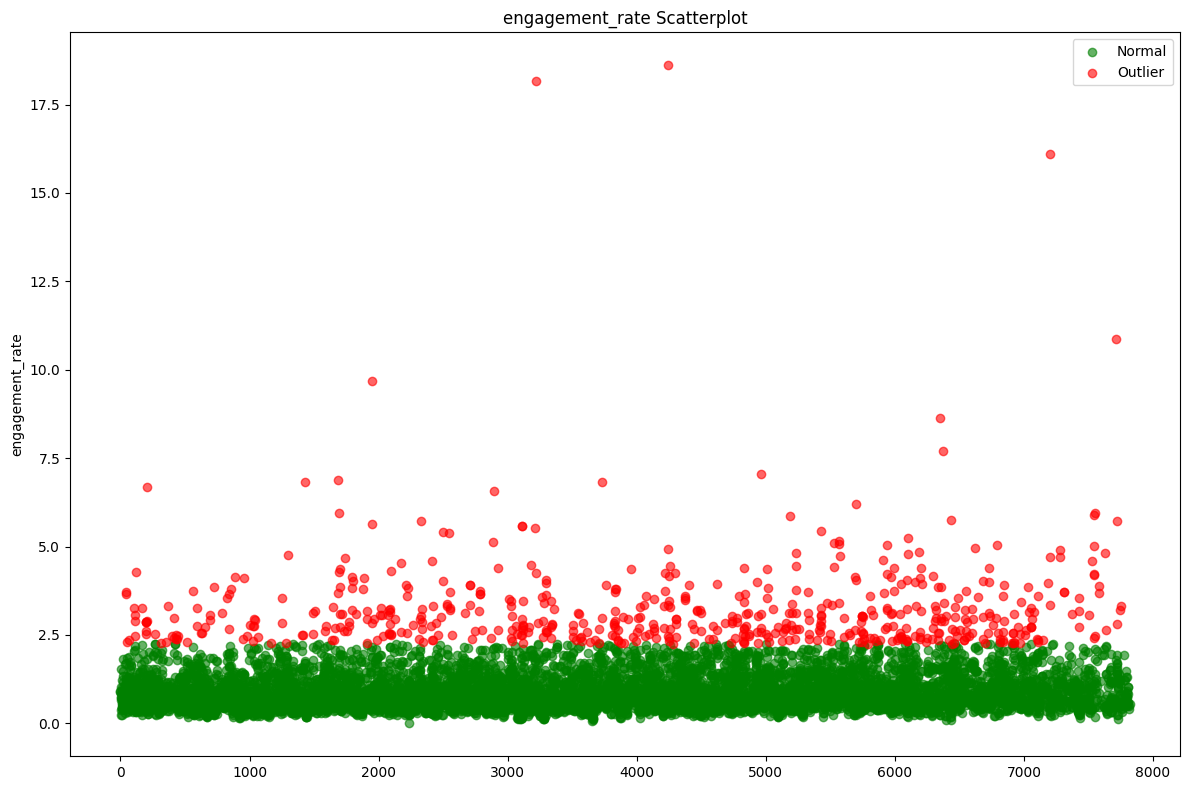

In [13]:
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound


columns_to_check = ["engagement_rate"]


plt.figure(figsize = (12, 8))
for i, col in enumerate(columns_to_check, 1):

    outliers, lower, upper = find_outliers_iqr(spotify_youtube_df_366_more, col)

   
    normal_values = spotify_youtube_df_366_more[(spotify_youtube_df_366_more[col] >= lower) & (spotify_youtube_df_366_more[col] <= upper)]

    
    plt.subplot(1, 1, i)
    plt.scatter(normal_values.index, normal_values[col], label = "Normal", alpha = 0.6, c = "green")
    plt.scatter(outliers.index, outliers[col], label = "Outlier", alpha=0.6, c = "red")
    plt.title(f"{col} Scatterplot")
    plt.ylabel(col)
    plt.legend()

    
    print(f"Total number of outliers in column {col}: {len(outliers)}")
    print(f"Lower limit: {lower}, Upper limit: {upper}")
    print("-" * 59)

plt.tight_layout()
plt.show()

In [ ]:
youtube_30_df=youtube_30_df[youtube_30_df['engagement_rate']<9.338507725109846]
spotify_youtube_df_31_90=spotify_youtube_df_31_90[spotify_youtube_df_31_90['engagement_rate']<4.602401258613792]
spotify_youtube_df_91_365=spotify_youtube_df_91_365[spotify_youtube_df_91_365['engagement_rate']<4.253191569584401]
spotify_youtube_df_366_more=spotify_youtube_df_366_more[spotify_youtube_df_366_more['engagement_rate']<2.251193229196198]

In [218]:
youtube_30_df_x = youtube_30_df.drop('engagement_rate',axis=1)
youtube_30_df_y = youtube_30_df['engagement_rate']

spotify_youtube_df_31_90_x = spotify_youtube_df_31_90.drop('engagement_rate',axis=1)
spotify_youtube_df_31_90_y = spotify_youtube_df_31_90['engagement_rate']

spotify_youtube_df_91_365_x = spotify_youtube_df_91_365.drop('engagement_rate',axis=1)
spotify_youtube_df_91_365_y = spotify_youtube_df_91_365['engagement_rate']

spotify_youtube_df_366_more_x = spotify_youtube_df_366_more.drop('engagement_rate',axis=1)
spotify_youtube_df_366_more_y = spotify_youtube_df_366_more['engagement_rate']

In [219]:
spotify_youtube_30X_train, spotify_youtube_30X_test, spotify_youtube_30y_train, spotify_youtube_30y_test = train_test_split(youtube_30_df_x, youtube_30_df_y, test_size=0.25, random_state=42)
spotify_youtube_df_31_90X_train, spotify_youtube_df_31_90X_test, spotify_youtube_df_31_90y_train, spotify_youtube_df_31_90y_test = train_test_split(spotify_youtube_df_31_90_x, spotify_youtube_df_31_90_y, test_size=0.25, random_state=42)
spotify_youtube_df_91_365X_train, spotify_youtube_df_91_365X_test, spotify_youtube_df_91_365y_train, spotify_youtube_df_91_365y_test = train_test_split(spotify_youtube_df_91_365_x, spotify_youtube_df_91_365_y, test_size=0.25, random_state=42)

In [ ]:
# Dados de treino 
sy_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train,spotify_youtube_df_91_365X_train,spotify_youtube_df_366_more_x])
sy_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train,spotify_youtube_df_91_365y_train,spotify_youtube_df_366_more_y])

# Normalização do treino
scaler_all = RobustScaler()
sy_x_train_scaled = scaler_all.fit_transform(sy_x_train)

In [221]:
# Normalização do treino de 30 dias
sy_30_x_train_scaled = scaler_all.transform(spotify_youtube_30X_train)

In [222]:
# Dados para treinar o modelo com dados de 0 a 90 dias
sy_90_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train])
sy_90_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train])

# Normalização do treino de 90 dias
sy_90_x_train_scaled = scaler_all.transform(sy_90_x_train)

In [223]:
# Dados para treinar o modelo com dados de 0 a 365 dias
sy_365_x_train=pd.concat([spotify_youtube_30X_train,spotify_youtube_df_31_90X_train,spotify_youtube_df_91_365X_train])
sy_365_y_train=pd.concat([spotify_youtube_30y_train,spotify_youtube_df_31_90y_train,spotify_youtube_df_91_365y_train])

# Normalização do treino de 90 dias
sy_365_x_train_scaled = scaler_all.transform(sy_365_x_train)

In [224]:
# Para testar o desempenho do modelo com videos com ate 30 dias
sy_30_x_test=spotify_youtube_30X_test
sy_30_y_test=spotify_youtube_30y_test

# Para testar o desempenho do modelo com videos com ate 90 dias
sy_90_x_test=pd.concat([spotify_youtube_30X_test,spotify_youtube_df_31_90X_test])
sy_90_y_test=pd.concat([spotify_youtube_30y_test,spotify_youtube_df_31_90y_test])

# Para testar o desempenho do modelo com videos com ate 1 ano
sy_365_x_test=pd.concat([spotify_youtube_30X_test,spotify_youtube_df_31_90X_test,spotify_youtube_df_91_365X_test])
sy_365_y_test=pd.concat([spotify_youtube_30y_test,spotify_youtube_df_31_90y_test,spotify_youtube_df_91_365y_test])

In [225]:
# Normalizção dos dados de teste de 30 dias
sy_30_x_test_scaled = scaler_all.transform(sy_30_x_test)

# Normalizção dos dados de teste de 90 dias
sy_90_x_test_scaled = scaler_all.transform(sy_90_x_test)

# Normalizção dos dados de teste de 365 dias
sy_365_x_test_scaled = scaler_all.transform(sy_365_x_test)

# Primeira esperimento com os dados (streams)

## Regressão com Random Forest

In [185]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [186]:
# Treinamento
rf.fit(sy_x_train,sy_y_train)

RandomForestRegressor(random_state=42)

In [187]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias
predictions_90_days_rf=rf.predict(sy_90_x_test)# 90 dias
predictions_365_days_rf=rf.predict(sy_365_x_test)# 365 dias

In [188]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.6842, desvio padrão: 6.5005


In [189]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 1.3242, desvio padrão: 4.6820


In [190]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_rf)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_rf) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 0.9873, desvio padrão: 3.9446


## Regressão com logistic regressor

In [191]:
lin_reg = LinearRegression() # Regressor logistico

In [192]:
# Treinamento
lin_reg.fit(sy_x_train, sy_y_train)

LinearRegression()

In [193]:
# Predição
predictions_30_days_lin=lin_reg.predict(sy_30_x_test)# 30 dias
predictions_90_days_lin=lin_reg.predict(sy_90_x_test)# 90 dias
predictions_365_days_lin=lin_reg.predict(sy_365_x_test)# 365 dias

In [194]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_lin)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_lin) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 8.0881, desvio padrão: 12.4980


In [195]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_lin)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_lin) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 3.0575, desvio padrão: 20.1997


In [196]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_lin)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_lin) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 2.6087, desvio padrão: 18.4174


## Regressão com XGBoost

In [197]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42) # xbg para regressão

In [198]:
# Treinamento
xgb_reg.fit(sy_x_train, sy_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [199]:
# Predição
predictions_30_days_xgb=xgb_reg.predict(sy_30_x_test)# 30 dias
predictions_90_days_xgb=xgb_reg.predict(sy_90_x_test)# 90 dias
predictions_365_days_xgb=xgb_reg.predict(sy_365_x_test)# 365 dias

In [200]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_xgb)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_xgb) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 4.0146, desvio padrão: 7.5191


In [201]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_xgb)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_xgb) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 1.5730, desvio padrão: 4.8019


In [202]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_xgb)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_xgb) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 1.3257, desvio padrão: 4.5124


## Regressão com MLP

In [226]:
mlp_reg = MLPRegressor(random_state=1, max_iter=2000, tol=0.001) # MLP para regressão

In [227]:
# Treinamento
mlp_reg.fit(sy_x_train,sy_y_train)

MLPRegressor(max_iter=2000, random_state=1, tol=0.001)

In [228]:
# Predição
predictions_30_days_mlp=mlp_reg.predict(sy_30_x_test)# 30 dias
predictions_90_days_mlp=mlp_reg.predict(sy_90_x_test)# 90 dias
predictions_365_days_mlp=mlp_reg.predict(sy_365_x_test)# 365 dias

In [229]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_mlp)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_mlp) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 21739.3871, desvio padrão: 39962.9022


In [230]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_mlp)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_mlp) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 18641.1335, desvio padrão: 43740.8588


In [231]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_mlp)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_mlp) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 18140.2559, desvio padrão: 40125.7311


# Primeira esperimento com os dados

## Regressão com Random Forest

In [286]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [287]:
# Treinamento
rf.fit(sy_x_train,sy_y_train)

RandomForestRegressor(random_state=42)

In [288]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias
predictions_90_days_rf=rf.predict(sy_90_x_test)# 90 dias
predictions_365_days_rf=rf.predict(sy_365_x_test)# 365 dias

In [289]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.1562, desvio padrão: 5.0005


In [290]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 1.6844, desvio padrão: 10.1863


In [291]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_rf)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_rf) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 1.3183, desvio padrão: 8.7402


## Regressão com logistic regressor

In [292]:
lin_reg = LinearRegression() # Regressor logistico

In [293]:
# Treinamento
lin_reg.fit(sy_x_train, sy_y_train)

LinearRegression()

In [294]:
# Predição
predictions_30_days_lin=lin_reg.predict(sy_30_x_test)# 30 dias
predictions_90_days_lin=lin_reg.predict(sy_90_x_test)# 90 dias
predictions_365_days_lin=lin_reg.predict(sy_365_x_test)# 365 dias

In [295]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_lin)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_lin) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 7.0513, desvio padrão: 11.4618


In [296]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_lin)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_lin) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 3.4343, desvio padrão: 23.2039


In [297]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_lin)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_lin) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 2.8189, desvio padrão: 19.1513


## Regressão com XGBoost

In [298]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42) # xbg para regressão

In [299]:
# Treinamento
xgb_reg.fit(sy_x_train, sy_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [300]:
# Predição
predictions_30_days_xgb=xgb_reg.predict(sy_30_x_test)# 30 dias
predictions_90_days_xgb=xgb_reg.predict(sy_90_x_test)# 90 dias
predictions_365_days_xgb=xgb_reg.predict(sy_365_x_test)# 365 dias

In [301]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_xgb)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_xgb) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.8066, desvio padrão: 5.9589


In [302]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_xgb)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_xgb) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 2.0280, desvio padrão: 11.0071


In [303]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_xgb)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_xgb) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 1.7388, desvio padrão: 9.8049


## Regressão com MLP

In [304]:
mlp_reg = MLPRegressor(random_state=1, max_iter=2000, tol=0.001) # MLP para regressão

In [305]:
# Treinamento
mlp_reg.fit(sy_x_train, sy_y_train)

MLPRegressor(max_iter=2000, random_state=1, tol=0.001)

In [306]:
# Predição
predictions_30_days_mlp=mlp_reg.predict(sy_30_x_test)# 30 dias
predictions_90_days_mlp=mlp_reg.predict(sy_90_x_test)# 90 dias
predictions_365_days_mlp=mlp_reg.predict(sy_365_x_test)# 365 dias

In [307]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_mlp)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_mlp) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 934.2614, desvio padrão: 558.5439


In [308]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_mlp)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_mlp) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 1257.1955, desvio padrão: 1513.7960


In [309]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_mlp)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_mlp) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 1238.4791, desvio padrão: 1415.2241


# Segundo Experimento (Streams)

Treinado com dados de 30 dias

In [209]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [210]:
# Treinamento
rf.fit(spotify_youtube_30X_train,spotify_youtube_30y_train)

RandomForestRegressor(random_state=42)

In [211]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias

In [212]:
# Erro quadratico medio para 30 dias 3.6842, desvio padrão: 6.5005
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.6585, desvio padrão: 6.3363


Treinado com dados de 90 dias

In [213]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [214]:
# Treinamento
rf.fit(sy_90_x_train,sy_90_y_train)

RandomForestRegressor(random_state=42)

In [215]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias

In [216]:
# Erro quadratico medio para 30 dias 3.6842, desvio padrão: 6.5005
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.5228, desvio padrão: 6.3460


In [217]:
predictions_90_days_rf=rf.predict(sy_90_x_test)# 90 dias

In [218]:
# Erro quadratico medio para 90 dias 3.6842, desvio padrão: 6.5005
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 2.3043, desvio padrão: 15.1386


Treinando com dados de 365 dias

In [219]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [220]:
# Treinamento
rf.fit(sy_365_x_train,sy_365_y_train)

RandomForestRegressor(random_state=42)

In [221]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias

In [222]:
# Erro quadratico medio para 30 dias 3.6842, desvio padrão: 6.5005
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.5896, desvio padrão: 6.3719


In [223]:
predictions_90_days_rf=rf.predict(sy_90_x_test)# 90 dias

In [224]:
# Erro quadratico medio para 90 dias 3.6842, desvio padrão: 6.5005
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 1.3361, desvio padrão: 4.7574


In [225]:
predictions_365_days_rf=rf.predict(sy_365_x_test)# 365 dia

In [226]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_rf)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_rf) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 1.0005, desvio padrão: 3.9877


# Segundo Experimento

Treinado com dados de 30 dias

In [310]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [311]:
# Treinamento
rf.fit(spotify_youtube_30X_train,spotify_youtube_30y_train)

RandomForestRegressor(random_state=42)

In [312]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias

In [313]:
# Erro quadratico medio para 30 dias 3.6842, desvio padrão: 6.5005
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.3231, desvio padrão: 4.7252


Treinado com dados de 90 dias

In [314]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [315]:
# Treinamento
rf.fit(sy_90_x_train,sy_90_y_train)

RandomForestRegressor(random_state=42)

In [316]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias

In [317]:
# Erro quadratico medio para 30 dias 3.6842, desvio padrão: 6.5005
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.2701, desvio padrão: 4.8983


In [318]:
predictions_90_days_rf=rf.predict(sy_90_x_test)# 90 dias

In [319]:
# Erro quadratico medio para 90 dias 3.6842, desvio padrão: 6.5005
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 2.6376, desvio padrão: 18.7631


Treinando com dados de 365 dias

In [320]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [321]:
# Treinamento
rf.fit(sy_365_x_train,sy_365_y_train)

RandomForestRegressor(random_state=42)

In [322]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias

In [323]:
# Erro quadratico medio para 30 dias 3.6842, desvio padrão: 6.5005
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.1841, desvio padrão: 4.9836


In [324]:
predictions_90_days_rf=rf.predict(sy_90_x_test)# 90 dias

In [325]:
# Erro quadratico medio para 90 dias 3.6842, desvio padrão: 6.5005
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 1.7369, desvio padrão: 10.5388


In [326]:
predictions_365_days_rf=rf.predict(sy_365_x_test)# 365 dia

In [327]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_rf)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_rf) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 1.3653, desvio padrão: 9.0155


# Terceiro experimento (Streams)

testando com todos os dados sem outliers

In [253]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [254]:
# Treinamento
rf.fit(sy_x_train,sy_y_train)

RandomForestRegressor(random_state=42)

In [255]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias
predictions_90_days_rf=rf.predict(sy_90_x_test)# 90 dias
predictions_365_days_rf=rf.predict(sy_365_x_test)# 365 dias

In [256]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.1114, desvio padrão: 3.8740


In [257]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 0.6672, desvio padrão: 1.6963


In [258]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_rf)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_rf) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 0.5070, desvio padrão: 1.3953


In [259]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42) # xbg para regressão

In [260]:
# Treinamento
xgb_reg.fit(sy_x_train, sy_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [261]:
# Predição
predictions_30_days_xgb=xgb_reg.predict(sy_30_x_test)# 30 dias
predictions_90_days_xgb=xgb_reg.predict(sy_90_x_test)# 90 dias
predictions_365_days_xgb=xgb_reg.predict(sy_365_x_test)# 365 dias

In [262]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_xgb)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_xgb) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 2.9611, desvio padrão: 3.6671


In [263]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_xgb)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_xgb) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 0.8149, desvio padrão: 1.6636


In [264]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_xgb)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_xgb) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 0.6846, desvio padrão: 1.4060


Testando treinamento com o tempo

In [265]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [266]:
# Treinamento
rf.fit(spotify_youtube_30X_train,spotify_youtube_30y_train)

RandomForestRegressor(random_state=42)

In [267]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias

In [268]:
# Erro quadratico medio para 30 dias 3.6842, desvio padrão: 6.5005
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 2.9814, desvio padrão: 3.9980


# Terceiro experimento

testando com todos os dados sem outliers

In [338]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [339]:
# Treinamento
rf.fit(sy_x_train,sy_y_train)

RandomForestRegressor(random_state=42)

In [340]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias
predictions_90_days_rf=rf.predict(sy_90_x_test)# 90 dias
predictions_365_days_rf=rf.predict(sy_365_x_test)# 365 dias

In [341]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.8129, desvio padrão: 6.1590


In [342]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 0.7655, desvio padrão: 2.4093


In [343]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_rf)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_rf) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 0.5393, desvio padrão: 1.9229


In [344]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42) # xbg para regressão

In [345]:
# Treinamento
xgb_reg.fit(sy_x_train, sy_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [346]:
# Predição
predictions_30_days_xgb=xgb_reg.predict(sy_30_x_test)# 30 dias
predictions_90_days_xgb=xgb_reg.predict(sy_90_x_test)# 90 dias
predictions_365_days_xgb=xgb_reg.predict(sy_365_x_test)# 365 dias

In [347]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_xgb)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_xgb) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.7937, desvio padrão: 6.4592


In [348]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_xgb)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_xgb) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 0.9708, desvio padrão: 2.5117


In [349]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_xgb)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_xgb) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 0.7687, desvio padrão: 2.0340


Testando treinamento com o tempo

In [350]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [351]:
# Treinamento
rf.fit(spotify_youtube_30X_train,spotify_youtube_30y_train)

RandomForestRegressor(random_state=42)

In [352]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test)# 30 dias

In [353]:
# Erro quadratico medio para 30 dias 3.6842, desvio padrão: 6.5005
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.8308, desvio padrão: 6.0046


# Quarto Experimento

Será testado o desempenho dos modelos com os dados normalizados

## Regressão com Random Forest

Historico:

MinMaxScaler:
*   Erro quadrático médio para músicas com até 30 dias: 3.1149, desvio padrão: 3.8710
*   Erro quadrático médio para músicas com até 90 dias: 0.6680, desvio padrão: 1.6990
*   Erro quadrático médio para músicas com até 365 dias: 0.5076, desvio padrão: 1.3991

StandardScaler:
*   Erro quadrático médio para músicas com até 30 dias: 3.1165, desvio padrão: 3.8772
*   Erro quadrático médio para músicas com até 90 dias: 0.6686, desvio padrão: 1.7018
*   Erro quadrático médio para músicas com até 365 dias: 0.5081, desvio padrão: 1.4011

RobustScaler:
*   Erro quadrático médio para músicas com até 30 dias: 3.1129, desvio padrão: 3.8635
*   Erro quadrático médio para músicas com até 90 dias: 0.6682, desvio padrão: 1.6985
*   Erro quadrático médio para músicas com até 365 dias: 0.5079, desvio padrão: 1.3991

Normalizer:
*   Erro quadrático médio para músicas com até 30 dias: 2.9457, desvio padrão: 4.8489
*   Erro quadrático médio para músicas com até 90 dias: 0.6635, desvio padrão: 1.9010
*   Erro quadrático médio para músicas com até 365 dias: 0.5047, desvio padrão: 1.5504

In [179]:
rf = RandomForestRegressor(n_estimators=100, random_state=42) # Random Forest

In [180]:
# Treinamento
rf.fit(sy_x_train_scaled,sy_y_train)

RandomForestRegressor(random_state=42)

In [181]:
# Predição
predictions_30_days_rf=rf.predict(sy_30_x_test_scaled)# 30 dias
predictions_90_days_rf=rf.predict(sy_90_x_test_scaled)# 90 dias
predictions_365_days_rf=rf.predict(sy_365_x_test_scaled)# 365 dias

In [182]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_rf)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_rf) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 3.1129, desvio padrão: 3.8635


In [183]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_rf)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_rf) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 0.6682, desvio padrão: 1.6985


In [184]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_rf)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_rf) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 0.5079, desvio padrão: 1.3991


## Regressão com linear regressor

Historico:

MinMaxScaler:
*   Erro quadrático médio para músicas com até 30 dias: 6.1833, desvio padrão: 9.4600
*   Erro quadrático médio para músicas com até 90 dias: 1.3535, desvio padrão: 3.5833
*   Erro quadrático médio para músicas com até 365 dias: 1.1140, desvio padrão: 2.8929

StandardScaler:
*   Erro quadrático médio para músicas com até 30 dias: 6.1833, desvio padrão: 9.4600
*   Erro quadrático médio para músicas com até 90 dias: 1.3535, desvio padrão: 3.5833
*   Erro quadrático médio para músicas com até 365 dias: 1.1140, desvio padrão: 2.8929

RobustScaler:
*   Erro quadrático médio para músicas com até 30 dias: 6.1833, desvio padrão: 9.4600
*   Erro quadrático médio para músicas com até 90 dias: 1.3535, desvio padrão: 3.5833
*   Erro quadrático médio para músicas com até 365 dias: 1.1140, desvio padrão: 2.8929

Normalizer:
*   Erro quadrático médio para músicas com até 30 dias: 6.0184, desvio padrão: 8.8357
*   Erro quadrático médio para músicas com até 90 dias: 1.5435, desvio padrão: 3.5891
*   Erro quadrático médio para músicas com até 365 dias: 1.2832, desvio padrão: 2.9782

In [191]:
lin_reg = LinearRegression() # Regressor logistico

In [192]:
# Treinamento
lin_reg.fit(sy_x_train_scaled, sy_y_train)

LinearRegression()

In [193]:
# Predição
predictions_30_days_lin=lin_reg.predict(sy_30_x_test_scaled)# 30 dias
predictions_90_days_lin=lin_reg.predict(sy_90_x_test_scaled)# 90 dias
predictions_365_days_lin=lin_reg.predict(sy_365_x_test_scaled)# 365 dias

In [194]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_lin)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_lin) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 6.1833, desvio padrão: 9.4600


In [195]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_lin)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_lin) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 1.3535, desvio padrão: 3.5833


In [196]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_lin)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_lin) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 1.1140, desvio padrão: 2.8929


## Regressão com XGBoost

Historico:

MinMaxScaler:
*   Erro quadrático médio para músicas com até 30 dias: 2.9611, desvio padrão: 3.6671
*   Erro quadrático médio para músicas com até 90 dias: 0.8149, desvio padrão: 1.6636
*   Erro quadrático médio para músicas com até 365 dias: 0.6846, desvio padrão: 1.4060

StandardScaler:
*   Erro quadrático médio para músicas com até 30 dias: 2.9611, desvio padrão: 3.6671
*   Erro quadrático médio para músicas com até 90 dias: 0.8149, desvio padrão: 1.6636
*   Erro quadrático médio para músicas com até 365 dias: 0.6846, desvio padrão: 1.4060

RobustScaler:
*   Erro quadrático médio para músicas com até 30 dias: 2.9611, desvio padrão: 3.6671
*   Erro quadrático médio para músicas com até 90 dias: 0.8149, desvio padrão: 1.6636
*   Erro quadrático médio para músicas com até 365 dias: 0.6846, desvio padrão: 1.4060

Normalizer:
*   Erro quadrático médio para músicas com até 30 dias: 3.4460, desvio padrão: 6.1793
*   Erro quadrático médio para músicas com até 90 dias: 0.8814, desvio padrão: 2.3126
*   Erro quadrático médio para músicas com até 365 dias: 0.7338, desvio padrão: 1.8873

In [197]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, random_state=42) # xbg para regressão

In [198]:
# Treinamento
xgb_reg.fit(sy_x_train_scaled, sy_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [199]:
# Predição
predictions_30_days_xgb=xgb_reg.predict(sy_30_x_test_scaled)# 30 dias
predictions_90_days_xgb=xgb_reg.predict(sy_90_x_test_scaled)# 90 dias
predictions_365_days_xgb=xgb_reg.predict(sy_365_x_test_scaled)# 365 dias

In [200]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_xgb)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_xgb) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 2.9611, desvio padrão: 3.6671


In [201]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_xgb)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_xgb) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 0.8149, desvio padrão: 1.6636


In [202]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_xgb)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_xgb) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 0.6846, desvio padrão: 1.4060


## Regressão com MLP

Historico:

MinMaxScaler:
*   Erro quadrático médio para músicas com até 30 dias: 4.7367, desvio padrão: 7.8737
*   Erro quadrático médio para músicas com até 90 dias: 1.1412, desvio padrão: 2.9292
*   Erro quadrático médio para músicas com até 365 dias: 0.9653, desvio padrão: 2.3759

StandardScaler:
*   Erro quadrático médio para músicas com até 30 dias: 4.9826, desvio padrão: 8.0931
*   Erro quadrático médio para músicas com até 90 dias: 1.1592, desvio padrão: 3.0179
*   Erro quadrático médio para músicas com até 365 dias: 0.9675, desvio padrão: 2.4341

RobustScaler:
*   Erro quadrático médio para músicas com até 30 dias: 4.9182, desvio padrão: 8.0452
*   Erro quadrático médio para músicas com até 90 dias: 1.1819, desvio padrão: 3.0158
*   Erro quadrático médio para músicas com até 365 dias: 0.9982, desvio padrão: 2.4439

Normalizer:
*   Erro quadrático médio para músicas com até 30 dias: 6.1813, desvio padrão: 9.4032
*   Erro quadrático médio para músicas com até 90 dias: 1.5411, desvio padrão: 3.7335
*   Erro quadrático médio para músicas com até 365 dias: 1.2797, desvio padrão: 3.0805

In [203]:
mlp_reg = MLPRegressor(random_state=1, max_iter=2000, tol=0.001) # MLP para regressão

In [204]:
# Treinamento
mlp_reg.fit(sy_x_train_scaled, sy_y_train)

MLPRegressor(max_iter=2000, random_state=1, tol=0.001)

In [205]:
# Predição
predictions_30_days_mlp=mlp_reg.predict(sy_30_x_test_scaled)# 30 dias
predictions_90_days_mlp=mlp_reg.predict(sy_90_x_test_scaled)# 90 dias
predictions_365_days_mlp=mlp_reg.predict(sy_365_x_test_scaled)# 365 dias

In [206]:
# Erro quadratico medio para 30 dias
mse_30_days = mean_squared_error(sy_30_y_test, predictions_30_days_mlp)

# Calculo Desvio padrão
squared_errors_30_days = (sy_30_y_test - predictions_30_days_mlp) ** 2
std_mse_30_days = np.std(squared_errors_30_days)

print(f'Erro quadrático médio para músicas com até 30 dias: {mse_30_days:.4f}, desvio padrão: {std_mse_30_days:.4f}')

Erro quadrático médio para músicas com até 30 dias: 4.9182, desvio padrão: 8.0452


In [207]:
# Erro quadratico medio para 90 dias
mse_90_days = mean_squared_error(sy_90_y_test, predictions_90_days_mlp)

# Calculo Desvio padrão
squared_errors_90_days = (sy_90_y_test - predictions_90_days_mlp) ** 2
std_mse_90_days = np.std(squared_errors_90_days)

print(f'Erro quadrático médio para músicas com até 90 dias: {mse_90_days:.4f}, desvio padrão: {std_mse_90_days:.4f}')

Erro quadrático médio para músicas com até 90 dias: 1.1819, desvio padrão: 3.0158


In [208]:
# Erro quadratico medio para 365 dias
mse_365_days = mean_squared_error(sy_365_y_test, predictions_365_days_mlp)

# Calculo Desvio padrão
squared_errors_365_days = (sy_365_y_test - predictions_365_days_mlp) ** 2
std_mse_365_days = np.std(squared_errors_365_days)

print(f'Erro quadrático médio para músicas com até 365 dias: {mse_365_days:.4f}, desvio padrão: {std_mse_365_days:.4f}')

Erro quadrático médio para músicas com até 365 dias: 0.9982, desvio padrão: 2.4439
